# Machine learning for modelling - Supervised Learning
## Food classification task

### Common libraries

In [16]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy, F1Score, Precision, Recall, ConfusionMatrix
import itertools
from scipy.spatial.distance import pdist, squareform
import numpy as np
import random

device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')

### Dataset split

In [ ]:
train_image_label = pd.read_csv('annot/train_info.csv', names=['image_name', 'label'])

# Split the dataset into training and validation sets 
train_df, val_df = train_test_split(train_image_label, train_size = 0.8, test_size=0.2, random_state=42)

reduced_train_df = []
for i in range(251):
    if train_df[train_df['label'] == i].shape[0] > 350:
        # If there are more than 350 samples, sample 350
        reduced_train_df.append(train_df[train_df['label'] == i].sample(350, random_state=42))
    else:
        # If there are less than 350 samples, take all available samples
        reduced_train_df.append(train_df[train_df['label'] == i])
reduced_train_df = pd.concat(reduced_train_df, ignore_index=True)

reduced_val_df = []
for i in range(251):
    if val_df[val_df['label'] == i].shape[0] > 30:
        # If there are more than 350 samples, sample 350
        reduced_val_df.append(val_df[val_df['label'] == i].sample(30, random_state=42))
    else:
        # If there are less than 350 samples, take all available samples
        reduced_val_df.append(val_df[val_df['label'] == i])
reduced_val_df = pd.concat(reduced_val_df, ignore_index=True)

## Helper functions

### Generic training routine

In [39]:
def run_training_routine(model, num_classes, num_epochs, training_dataloader, validation_dataloader, criterion, optimizer, scheduler):
    training_accuracy = Accuracy(num_classes=num_classes, task='multiclass').to(device)
    validation_accuracy = Accuracy(num_classes=num_classes, task='multiclass').to(device)

    training_per_batch_losses = []
    training_per_batch_accuracies = []
    validation_per_batch_losses = []
    validation_per_batch_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(tqdm(training_dataloader)):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            training_per_batch_losses.append(loss.item())
            training_per_batch_accuracies.append(training_accuracy(outputs, labels).item())

        # Compute and print epoch-level training metrics
        avg_train_loss = sum(training_per_batch_losses[-len(training_dataloader):]) / len(training_dataloader)
        avg_train_acc = sum(training_per_batch_accuracies[-len(training_dataloader):]) / len(training_dataloader)
        print(f"[Epoch {epoch+1}] Training Loss: {avg_train_loss:.4f} | Training Accuracy: {avg_train_acc*100:.2f}%")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(validation_dataloader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                validation_per_batch_losses.append(loss.item())
                validation_per_batch_accuracies.append(validation_accuracy(outputs, labels).item())

        avg_val_loss = sum(validation_per_batch_losses[-len(validation_dataloader):]) / len(validation_dataloader)
        avg_val_acc = sum(validation_per_batch_accuracies[-len(validation_dataloader):]) / len(validation_dataloader)
        print(f"[Epoch {epoch+1}] Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc*100:.2f}%")

        scheduler.step(avg_val_loss)

    return training_per_batch_losses, training_per_batch_accuracies, validation_per_batch_losses, validation_per_batch_accuracies


### Helper function to display metrics

In [10]:
def compute_metrics(model, test_dataloader):    
# Accuracy, F1Score, Precision, Recall
    accuracy = Accuracy(num_classes=251, task='multiclass').to(device)

    f1_macro = F1Score(num_classes=251, task='multiclass', average='macro').to(device)
    f1_weighted = F1Score(num_classes=251, task='multiclass', average='weighted').to(device)

    precision_macro = Precision(num_classes=251, task='multiclass', average='macro').to(device)
    precision_weighted = Precision(num_classes=251, task='multiclass', average='weighted').to(device)

    recall_macro = Recall(num_classes=251, task='multiclass', average='macro').to(device)
    recall_weighted = Recall(num_classes=251, task='multiclass', average='weighted').to(device)

    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Compute metrics
            accuracy(outputs, labels)
            f1_macro(outputs, labels)
            f1_weighted(outputs, labels)
            precision_macro(outputs, labels)
            precision_weighted(outputs, labels)
            recall_macro(outputs, labels)
            recall_weighted(outputs, labels)  

    # Print metrics
    print(f"Accuracy: {accuracy.compute().item() * 100:.2f}%")
    print(f"F1 Score (Macro): {f1_macro.compute().item()* 100:.2f}%")
    print(f"F1 Score (Weighted): {f1_weighted.compute().item()* 100:.2f}%")
    print(f"Precision (Macro): {precision_macro.compute().item()* 100:.2f}%")
    print(f"Precision (Weighted): {precision_weighted.compute().item()* 100:.2f}%")
    print(f"Recall (Macro): {recall_macro.compute().item()* 100:.2f}%")

### Helper function to plot training curves

In [11]:
def plot_training_curves(training_per_batch_losses, training_per_batch_accuracies, validation_per_batch_losses, validation_per_batch_accuracies, num_epochs, train_dataloader, val_dataloader):
    # convert curves to be per epoch and plot them
    epochs = list(range(1, num_epochs + 1))
    train_losses = [sum(training_per_batch_losses[i:i+len(train_dataloader)]) / len(train_dataloader) for i in range(0, len(training_per_batch_losses), len(train_dataloader))]
    val_losses = [sum(validation_per_batch_losses[i:i+len(val_dataloader)]) / len(val_dataloader) for i in range(0, len(validation_per_batch_losses), len(val_dataloader))]
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    train_accuracies = [sum(training_per_batch_accuracies[i:i+len(train_dataloader)]) / len(train_dataloader) for i in range(0, len(training_per_batch_accuracies), len(train_dataloader))]
    val_accuracies = [sum(validation_per_batch_accuracies[i:i+len(val_dataloader)]) / len(val_dataloader) for i in range(0, len(validation_per_batch_accuracies), len(val_dataloader))]
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Supevised Approach

### Dataset class definition

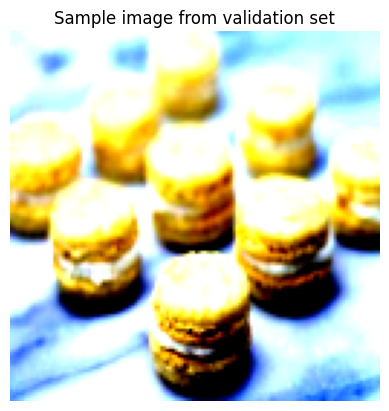

In [3]:
class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, class_list, image_folder, augmentation=True):
        self.file_class = class_list
        self.image_folder = image_folder
        self.augmentation = augmentation

    def __len__(self):
        return len(self.file_class)
    
    def __getitem__(self, idx):
        image_name = self.file_class.iloc[idx, 0]
        image_path = f"{self.image_folder}/{image_name}"
        image = Image.open(image_path).convert('RGB')

        label = self.file_class.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        if self.augmentation:
            preprocessing = v2.Compose([
                v2.Resize((128, 128)),
                v2.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
                v2.RandomHorizontalFlip(p=0.5),
                v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                v2.RandomGrayscale(p=0.1),
                v2.RandomErasing(p=0.3),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]).to(device)
        else:
            preprocessing = v2.Compose([
                v2.Resize((128, 128)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]).to(device)

        image = preprocessing(image)

        return image, label

train_dataset = FoodDataset(reduced_train_df, 'train/train_set', augmentation=True)

val_dataset = FoodDataset(reduced_val_df, 'train/train_set', augmentation=False)
image_val, label_val = val_dataset[0]

test_df = pd.read_csv('annot/val_info.csv')
test_dataset = FoodDataset(test_df, 'val/val_set')

plt.imshow(image_val.clip(min=0, max=1).permute(1, 2, 0).numpy())
plt.title(f"Sample image from validation set")
plt.axis('off')
plt.show()

### Dataloaders

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### Main network architecture

In [5]:
#Squeeze-and-Excitation block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.SiLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# Depthwise separable residual block with SE and SiLU
class ResidualDWBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=stride, padding=1, groups=in_c),
            nn.BatchNorm2d(in_c),
            nn.SiLU(),
            nn.Conv2d(in_c, out_c, kernel_size=1),
            nn.BatchNorm2d(out_c),
            SEBlock(out_c)
        )
        self.skip = nn.Identity()
        if in_c != out_c or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_c)
            )
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.main(x) + self.skip(x))

# The full CNN model
class ResidualFoodCNN(nn.Module):
    def __init__(self, num_classes=251):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU()
        )

        self.layer1 = nn.Sequential(
            ResidualDWBlock(64, 128, stride=2),
            ResidualDWBlock(128, 128)
        )
        self.layer2 = nn.Sequential(
            ResidualDWBlock(128, 256, stride=2),
            ResidualDWBlock(256, 256)
        )
        self.layer3 = nn.Sequential(
            ResidualDWBlock(256, 512, stride=2),
            ResidualDWBlock(512, 512)
        )
        self.layer4 = nn.Sequential(
            ResidualDWBlock(512, 512),  # No further downsampling
            ResidualDWBlock(512, 512)
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.SiLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


cnn = ResidualFoodCNN(num_classes=251)
cnn.to(device)
print(f"Parameters count: {sum(p.numel() for p in cnn.parameters() if p.requires_grad):,}")

Parameters count: 2,191,019


### Training routine

In [ ]:
num_epochs = 50
optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

training_per_batch_losses, training_per_batch_accuracies, validation_per_batch_losses, validation_per_batch_accuracies = run_training_routine(
    cnn,
    num_classes=251, 
    num_epochs=num_epochs, 
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    criterion=nn.CrossEntropyLoss().to(device), 
    optimizer=optimizer, 
    scheduler=scheduler
)

100%|██████████| 1314/1314 [07:45<00:00,  2.82it/s]


[Epoch 1] Training Loss: 4.8036 | Training Accuracy: 5.46%


100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


[Epoch 1] Validation Loss: 4.4482 | Validation Accuracy: 9.61%


100%|██████████| 1314/1314 [08:04<00:00,  2.71it/s]


[Epoch 2] Training Loss: 4.1623 | Training Accuracy: 12.89%


100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


[Epoch 2] Validation Loss: 3.7881 | Validation Accuracy: 18.77%


100%|██████████| 1314/1314 [07:34<00:00,  2.89it/s]


[Epoch 3] Training Loss: 3.7617 | Training Accuracy: 19.28%


100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


[Epoch 3] Validation Loss: 3.4661 | Validation Accuracy: 24.21%


100%|██████████| 1314/1314 [07:32<00:00,  2.90it/s]


[Epoch 4] Training Loss: 3.4835 | Training Accuracy: 23.68%


100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


[Epoch 4] Validation Loss: 3.2232 | Validation Accuracy: 28.36%


100%|██████████| 1314/1314 [07:31<00:00,  2.91it/s]


[Epoch 5] Training Loss: 3.2628 | Training Accuracy: 27.29%


100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


[Epoch 5] Validation Loss: 3.1366 | Validation Accuracy: 29.91%


100%|██████████| 1314/1314 [07:31<00:00,  2.91it/s]


[Epoch 6] Training Loss: 3.0958 | Training Accuracy: 30.49%


100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


[Epoch 6] Validation Loss: 2.9671 | Validation Accuracy: 32.97%


100%|██████████| 1314/1314 [07:35<00:00,  2.88it/s]


[Epoch 7] Training Loss: 2.9439 | Training Accuracy: 33.18%


100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


[Epoch 7] Validation Loss: 2.8404 | Validation Accuracy: 35.43%


100%|██████████| 1314/1314 [08:05<00:00,  2.71it/s]


[Epoch 8] Training Loss: 2.8288 | Training Accuracy: 35.37%


100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


[Epoch 8] Validation Loss: 2.7765 | Validation Accuracy: 36.93%


100%|██████████| 1314/1314 [07:40<00:00,  2.85it/s]


[Epoch 9] Training Loss: 2.7166 | Training Accuracy: 37.29%


100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


[Epoch 9] Validation Loss: 2.7057 | Validation Accuracy: 38.38%


100%|██████████| 1314/1314 [07:46<00:00,  2.82it/s]


[Epoch 10] Training Loss: 2.6244 | Training Accuracy: 39.12%


100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


[Epoch 10] Validation Loss: 2.6962 | Validation Accuracy: 38.61%


100%|██████████| 1314/1314 [07:52<00:00,  2.78it/s]


[Epoch 11] Training Loss: 2.5334 | Training Accuracy: 40.59%


100%|██████████| 118/118 [00:19<00:00,  6.05it/s]


[Epoch 11] Validation Loss: 2.6212 | Validation Accuracy: 40.69%


100%|██████████| 1314/1314 [07:29<00:00,  2.92it/s]


[Epoch 12] Training Loss: 2.4563 | Training Accuracy: 42.19%


100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


[Epoch 12] Validation Loss: 2.5684 | Validation Accuracy: 41.52%


100%|██████████| 1314/1314 [07:48<00:00,  2.81it/s]


[Epoch 13] Training Loss: 2.3828 | Training Accuracy: 43.41%


100%|██████████| 118/118 [00:22<00:00,  5.36it/s]


[Epoch 13] Validation Loss: 2.5743 | Validation Accuracy: 41.33%


100%|██████████| 1314/1314 [08:04<00:00,  2.71it/s]


[Epoch 14] Training Loss: 2.2994 | Training Accuracy: 45.36%


100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


[Epoch 14] Validation Loss: 2.5725 | Validation Accuracy: 40.91%


100%|██████████| 1314/1314 [07:53<00:00,  2.77it/s]


[Epoch 15] Training Loss: 2.2387 | Training Accuracy: 46.09%


100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


[Epoch 15] Validation Loss: 2.5252 | Validation Accuracy: 42.68%


100%|██████████| 1314/1314 [07:35<00:00,  2.89it/s]


[Epoch 16] Training Loss: 2.1700 | Training Accuracy: 47.37%


100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


[Epoch 16] Validation Loss: 2.5229 | Validation Accuracy: 43.39%


100%|██████████| 1314/1314 [07:33<00:00,  2.90it/s]


[Epoch 17] Training Loss: 2.1090 | Training Accuracy: 48.69%


100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


[Epoch 17] Validation Loss: 2.5019 | Validation Accuracy: 43.52%


100%|██████████| 1314/1314 [07:33<00:00,  2.90it/s]


[Epoch 18] Training Loss: 2.0503 | Training Accuracy: 49.85%


100%|██████████| 118/118 [00:20<00:00,  5.90it/s]


[Epoch 18] Validation Loss: 2.5384 | Validation Accuracy: 43.52%


100%|██████████| 1314/1314 [07:32<00:00,  2.90it/s]


[Epoch 19] Training Loss: 1.9917 | Training Accuracy: 50.87%


100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


[Epoch 19] Validation Loss: 2.5183 | Validation Accuracy: 44.58%


100%|██████████| 1314/1314 [07:32<00:00,  2.91it/s]


[Epoch 20] Training Loss: 1.9326 | Training Accuracy: 52.22%


100%|██████████| 118/118 [00:20<00:00,  5.90it/s]


[Epoch 20] Validation Loss: 2.5710 | Validation Accuracy: 44.01%


100%|██████████| 1314/1314 [07:34<00:00,  2.89it/s]


[Epoch 21] Training Loss: 1.8778 | Training Accuracy: 53.22%


100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


[Epoch 21] Validation Loss: 2.5484 | Validation Accuracy: 43.84%


100%|██████████| 1314/1314 [07:35<00:00,  2.89it/s]


[Epoch 22] Training Loss: 1.8316 | Training Accuracy: 53.97%


100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


[Epoch 22] Validation Loss: 2.6011 | Validation Accuracy: 43.29%


100%|██████████| 1314/1314 [07:34<00:00,  2.89it/s]


[Epoch 23] Training Loss: 1.7842 | Training Accuracy: 54.96%


100%|██████████| 118/118 [00:20<00:00,  5.82it/s]


[Epoch 23] Validation Loss: 2.5539 | Validation Accuracy: 44.62%


100%|██████████| 1314/1314 [07:34<00:00,  2.89it/s]


[Epoch 24] Training Loss: 1.5301 | Training Accuracy: 60.66%


100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


[Epoch 24] Validation Loss: 2.5045 | Validation Accuracy: 46.56%


100%|██████████| 1314/1314 [07:33<00:00,  2.90it/s]


[Epoch 25] Training Loss: 1.4748 | Training Accuracy: 61.89%


100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


[Epoch 25] Validation Loss: 2.5542 | Validation Accuracy: 46.59%


100%|██████████| 1314/1314 [09:01<00:00,  2.43it/s]


[Epoch 26] Training Loss: 1.4244 | Training Accuracy: 62.82%


100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


[Epoch 26] Validation Loss: 2.5511 | Validation Accuracy: 47.18%


100%|██████████| 1314/1314 [14:12<00:00,  1.54it/s]


[Epoch 27] Training Loss: 1.3910 | Training Accuracy: 63.69%


100%|██████████| 118/118 [00:20<00:00,  5.88it/s]


[Epoch 27] Validation Loss: 2.5834 | Validation Accuracy: 45.99%


100%|██████████| 1314/1314 [12:34<00:00,  1.74it/s]


[Epoch 28] Training Loss: 1.3548 | Training Accuracy: 64.48%


100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


[Epoch 28] Validation Loss: 2.5875 | Validation Accuracy: 46.76%


100%|██████████| 1314/1314 [11:22<00:00,  1.93it/s]


[Epoch 29] Training Loss: 1.3283 | Training Accuracy: 65.11%


100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


[Epoch 29] Validation Loss: 2.6299 | Validation Accuracy: 46.70%


100%|██████████| 1314/1314 [07:31<00:00,  2.91it/s]


[Epoch 30] Training Loss: 1.1887 | Training Accuracy: 68.21%


100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


[Epoch 30] Validation Loss: 2.5921 | Validation Accuracy: 47.92%


100%|██████████| 1314/1314 [07:30<00:00,  2.91it/s]


[Epoch 31] Training Loss: 1.1602 | Training Accuracy: 69.28%


100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


[Epoch 31] Validation Loss: 2.6327 | Validation Accuracy: 47.27%


100%|██████████| 1314/1314 [07:31<00:00,  2.91it/s]


[Epoch 32] Training Loss: 1.1380 | Training Accuracy: 69.81%


100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


[Epoch 32] Validation Loss: 2.6404 | Validation Accuracy: 47.29%


100%|██████████| 1314/1314 [07:33<00:00,  2.90it/s]


[Epoch 33] Training Loss: 1.1233 | Training Accuracy: 70.08%


100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


[Epoch 33] Validation Loss: 2.6474 | Validation Accuracy: 48.32%


100%|██████████| 1314/1314 [07:33<00:00,  2.90it/s]


[Epoch 34] Training Loss: 1.1045 | Training Accuracy: 70.41%


100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


[Epoch 34] Validation Loss: 2.6441 | Validation Accuracy: 48.20%


100%|██████████| 1314/1314 [07:32<00:00,  2.90it/s]


[Epoch 35] Training Loss: 1.0827 | Training Accuracy: 70.94%


100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


[Epoch 35] Validation Loss: 2.6898 | Validation Accuracy: 47.79%


100%|██████████| 1314/1314 [07:32<00:00,  2.91it/s]


[Epoch 36] Training Loss: 1.0184 | Training Accuracy: 72.75%


100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


[Epoch 36] Validation Loss: 2.6965 | Validation Accuracy: 47.55%


100%|██████████| 1314/1314 [07:33<00:00,  2.90it/s]


[Epoch 37] Training Loss: 1.0035 | Training Accuracy: 73.20%


100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


[Epoch 37] Validation Loss: 2.7217 | Validation Accuracy: 48.22%


100%|██████████| 1314/1314 [07:32<00:00,  2.91it/s]


[Epoch 38] Training Loss: 0.9819 | Training Accuracy: 73.81%


100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


[Epoch 38] Validation Loss: 2.7403 | Validation Accuracy: 47.60%


100%|██████████| 1314/1314 [07:31<00:00,  2.91it/s]


[Epoch 39] Training Loss: 0.9791 | Training Accuracy: 73.66%


100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


[Epoch 39] Validation Loss: 2.7254 | Validation Accuracy: 47.87%


100%|██████████| 1314/1314 [07:30<00:00,  2.91it/s]


[Epoch 40] Training Loss: 0.9708 | Training Accuracy: 73.87%


100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


[Epoch 40] Validation Loss: 2.7594 | Validation Accuracy: 47.18%


100%|██████████| 1314/1314 [07:31<00:00,  2.91it/s]


[Epoch 41] Training Loss: 0.9528 | Training Accuracy: 74.26%


100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


[Epoch 41] Validation Loss: 2.7331 | Validation Accuracy: 47.85%


100%|██████████| 1314/1314 [07:31<00:00,  2.91it/s]


[Epoch 42] Training Loss: 0.9261 | Training Accuracy: 75.14%


100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


[Epoch 42] Validation Loss: 2.7749 | Validation Accuracy: 47.13%


100%|██████████| 1314/1314 [07:31<00:00,  2.91it/s]


[Epoch 43] Training Loss: 0.9095 | Training Accuracy: 75.44%


100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


[Epoch 43] Validation Loss: 2.7718 | Validation Accuracy: 48.22%


100%|██████████| 1314/1314 [07:36<00:00,  2.88it/s]


[Epoch 44] Training Loss: 0.9165 | Training Accuracy: 75.07%


100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


[Epoch 44] Validation Loss: 2.7692 | Validation Accuracy: 48.02%


100%|██████████| 1314/1314 [07:38<00:00,  2.87it/s]


[Epoch 45] Training Loss: 0.9114 | Training Accuracy: 75.43%


100%|██████████| 118/118 [00:20<00:00,  5.79it/s]


[Epoch 45] Validation Loss: 2.7596 | Validation Accuracy: 48.02%


100%|██████████| 1314/1314 [07:36<00:00,  2.88it/s]


[Epoch 46] Training Loss: 0.9009 | Training Accuracy: 75.69%


100%|██████████| 118/118 [00:20<00:00,  5.89it/s]


[Epoch 46] Validation Loss: 2.7905 | Validation Accuracy: 47.61%


100%|██████████| 1314/1314 [07:35<00:00,  2.88it/s]


[Epoch 47] Training Loss: 0.8951 | Training Accuracy: 75.88%


100%|██████████| 118/118 [00:20<00:00,  5.85it/s]


[Epoch 47] Validation Loss: 2.7772 | Validation Accuracy: 48.09%


100%|██████████| 1314/1314 [07:33<00:00,  2.90it/s]


[Epoch 48] Training Loss: 0.8821 | Training Accuracy: 76.22%


100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


[Epoch 48] Validation Loss: 2.7838 | Validation Accuracy: 47.99%


100%|██████████| 1314/1314 [07:31<00:00,  2.91it/s]


[Epoch 49] Training Loss: 0.8787 | Training Accuracy: 76.34%


100%|██████████| 118/118 [00:20<00:00,  5.90it/s]


[Epoch 49] Validation Loss: 2.7737 | Validation Accuracy: 47.96%


100%|██████████| 1314/1314 [07:44<00:00,  2.83it/s]


[Epoch 50] Training Loss: 0.8777 | Training Accuracy: 76.42%


100%|██████████| 118/118 [00:20<00:00,  5.71it/s]

[Epoch 50] Validation Loss: 2.7870 | Validation Accuracy: 48.34%


### Training and validation curves

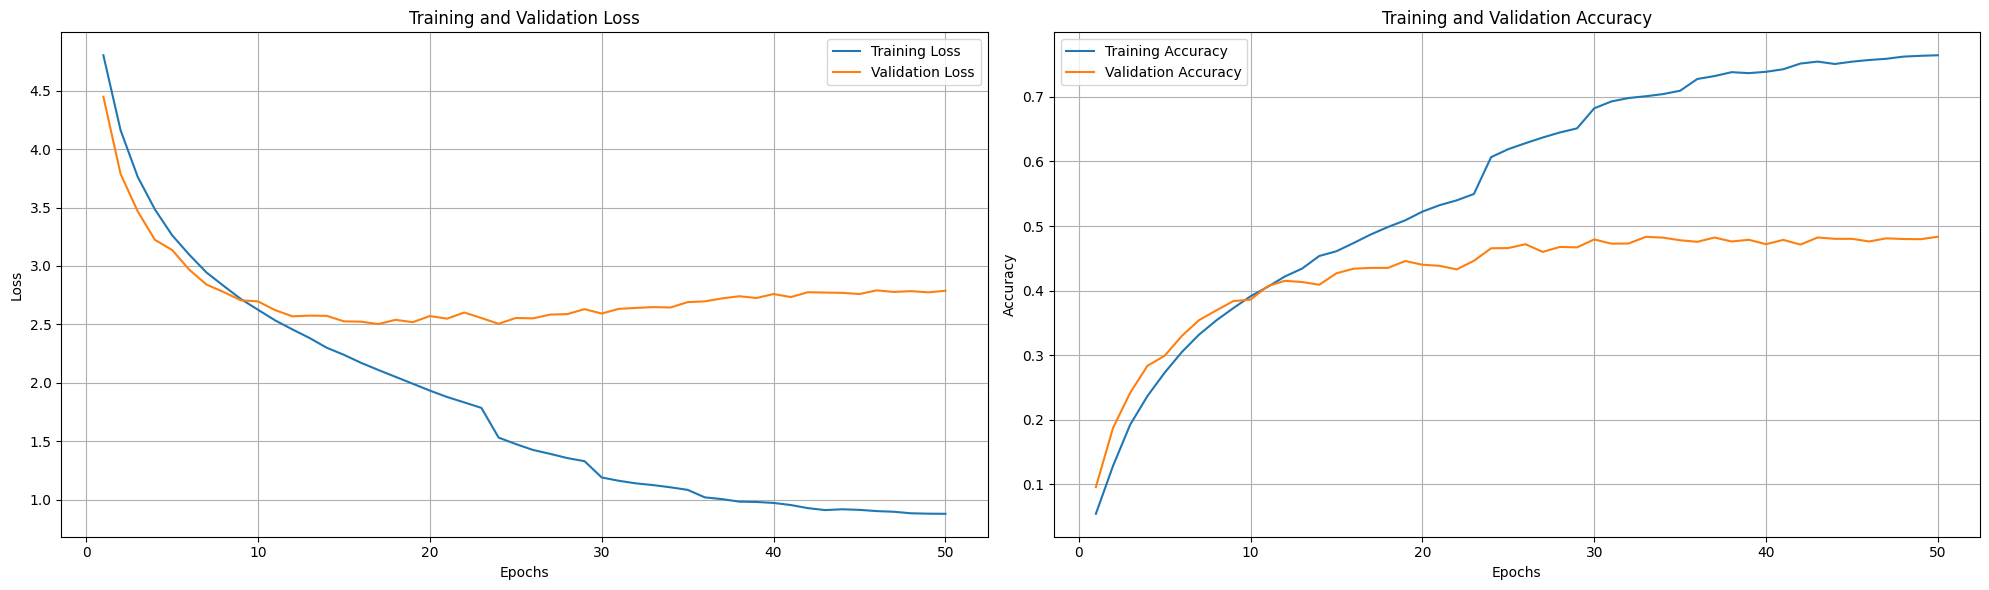

In [12]:
plot_training_curves(training_per_batch_losses, training_per_batch_accuracies, validation_per_batch_losses, validation_per_batch_accuracies, num_epochs, train_dataloader, val_dataloader)

### Metrics

In [13]:
compute_metrics(cnn, test_dataloader)

100%|██████████| 188/188 [02:07<00:00,  1.47it/s]

Accuracy: 51.38%
F1 Score (Macro): 49.62%
F1 Score (Weighted): 51.30%
Precision (Macro): 50.41%
Precision (Weighted): 52.21%
Recall (Macro): 49.91%


In [14]:
torch.save(cnn.state_dict(), 'final_models/cnn.pth')

# Self-supervised Approach

## First pretext task: jigsaw puzzle resolution

### Dataset class definition and helper functions for puzzles generation

In [32]:
def generate_diverse_permutations(n_patches, n_permutations, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    # Generate all possible permutations
    all_perms = list(itertools.permutations(range(n_patches)))

    # Randomly sample a subset to reduce computational cost
    sample_size = min(5000, len(all_perms))  # cap for speed
    sampled_perms = random.sample(all_perms, sample_size)

    # Compute Hamming distance matrix between all sampled permutations
    perm_array = np.array(sampled_perms)
    dists = squareform(pdist(perm_array, metric='hamming'))

    # Greedy selection of diverse permutations
    selected = [0]
    for _ in range(1, n_permutations):
        # Find the permutation that is farthest from the already selected ones
        remaining = list(set(range(len(perm_array))) - set(selected))
        min_dist = [min(dists[i][selected]) for i in remaining]
        next_idx = remaining[np.argmax(min_dist)]
        selected.append(next_idx)

    diverse_perms = [tuple(perm_array[i]) for i in selected]
    return diverse_perms

perm_set = generate_diverse_permutations(n_patches=9, n_permutations=100, seed=42)

def jigsaw_puzzle_patches(image, grid_size=3, perm_set=None):
    """
    Given an image, return permuted patches and the permutation index.
    
    Args:
        image (Tensor): (C, H, W)
        grid_size (int): number of grid divisions per side (default: 3)
        perm_set (List[List[int]]): list of permutations (length N^2 each)
        
    Returns:
        patch_tensor: (N, C, h, w) permuted patches
        perm_index: int in [0, len(perm_set)-1]
    """
    C, H, W = image.shape
    patch_h, patch_w = H // grid_size, W // grid_size
    N = grid_size * grid_size

    # Step 1: extract patches (C, h, w) each
    patches = []
    for i in range(grid_size):
        for j in range(grid_size):
            top = i * patch_h
            left = j * patch_w
            patch = image[:, top:top + patch_h, left:left + patch_w]
            patches.append(patch)

    # Stack into tensor (N, C, h, w)
    patches = torch.stack(patches, dim=0)

    # Step 2: pick random permutation
    if perm_set is None:
        perm_set = [list(range(N))]  # default identity
    perm_index = random.randint(0, len(perm_set) - 1)
    perm = perm_set[perm_index]

    # Step 3: permute patches
    permuted_patches = [patches[i] for i in perm]

    return permuted_patches, perm_index

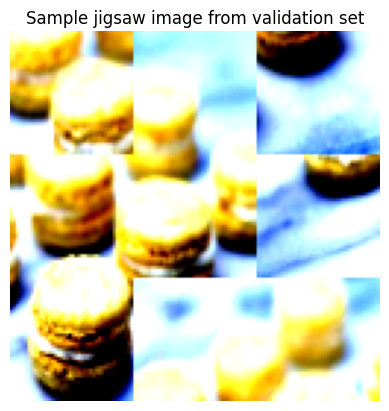

In [33]:
class JigsawDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, grid_size=3, perm_set=None):
        self.dataset = dataset
        self.grid_size = grid_size
        self.perm_set = perm_set

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        permuted_patches, perm_index = jigsaw_puzzle_patches(image, self.grid_size, self.perm_set)

        # Convert patches to a single image since the cnn expects a single image input
        jigsaw_image = torch.cat([torch.cat(permuted_patches[i:i + self.grid_size], dim=1) for i in range(0, len(permuted_patches), self.grid_size)], dim=2)

        return jigsaw_image, perm_index

    
jigsaw_dataset_train = JigsawDataset(train_dataset, grid_size=3, perm_set=perm_set)
jigsaw_dataset_val = JigsawDataset(val_dataset, grid_size=3, perm_set=perm_set)

jigsaw_train_dataloader = torch.utils.data.DataLoader(jigsaw_dataset_train, batch_size=32, shuffle=True)
jigsaw_val_dataloader = torch.utils.data.DataLoader(jigsaw_dataset_val, batch_size=32, shuffle=False)

plt.imshow(jigsaw_dataset_val[0][0].clip(min=0, max=1).permute(1, 2, 0).cpu().numpy())
plt.title(f"Sample jigsaw image from validation set")
plt.axis('off')
plt.show()

### Training routine

In [ ]:
first_task_model = ResidualFoodCNN(num_classes=100)
first_task_model.to(device)

num_epochs = 10
optimizer = torch.optim.AdamW(first_task_model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

training_per_batch_losses, training_per_batch_accuracies, validation_per_batch_losses, validation_per_batch_accuracies = run_training_routine(
    first_task_model,
    num_classes=100, 
    num_epochs=num_epochs, 
    training_dataloader=jigsaw_train_dataloader, 
    validation_dataloader=jigsaw_val_dataloader,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=optimizer,
    scheduler=scheduler
)

100%|██████████| 2627/2627 [16:19<00:00,  2.68it/s]


[Epoch 1] Training Loss: 2.3236 | Training Accuracy: 42.52%


100%|██████████| 235/235 [01:04<00:00,  3.66it/s]


[Epoch 1] Validation Loss: 0.6455 | Validation Accuracy: 82.89%


100%|██████████| 2627/2627 [08:38<00:00,  5.07it/s]


[Epoch 2] Training Loss: 0.6073 | Training Accuracy: 83.72%


100%|██████████| 235/235 [00:23<00:00, 10.05it/s]


[Epoch 2] Validation Loss: 0.3115 | Validation Accuracy: 91.48%


100%|██████████| 2627/2627 [08:30<00:00,  5.15it/s]


[Epoch 3] Training Loss: 0.4219 | Training Accuracy: 88.57%


100%|██████████| 235/235 [00:23<00:00, 10.18it/s]


[Epoch 3] Validation Loss: 0.2641 | Validation Accuracy: 92.65%


100%|██████████| 2627/2627 [08:26<00:00,  5.19it/s]


[Epoch 4] Training Loss: 0.3384 | Training Accuracy: 90.66%


100%|██████████| 235/235 [00:23<00:00,  9.86it/s]


[Epoch 4] Validation Loss: 0.2056 | Validation Accuracy: 94.35%


100%|██████████| 2627/2627 [08:25<00:00,  5.19it/s]


[Epoch 5] Training Loss: 0.2958 | Training Accuracy: 91.82%


100%|██████████| 235/235 [00:23<00:00, 10.11it/s]


[Epoch 5] Validation Loss: 0.1790 | Validation Accuracy: 94.71%


100%|██████████| 2627/2627 [08:21<00:00,  5.24it/s]


[Epoch 6] Training Loss: 0.2594 | Training Accuracy: 92.69%


100%|██████████| 235/235 [00:22<00:00, 10.32it/s]


[Epoch 6] Validation Loss: 0.1572 | Validation Accuracy: 95.43%


100%|██████████| 2627/2627 [08:22<00:00,  5.23it/s]


[Epoch 7] Training Loss: 0.2318 | Training Accuracy: 93.51%


100%|██████████| 235/235 [00:24<00:00,  9.78it/s]


[Epoch 7] Validation Loss: 0.1335 | Validation Accuracy: 96.16%


100%|██████████| 2627/2627 [08:18<00:00,  5.27it/s]


[Epoch 8] Training Loss: 0.2092 | Training Accuracy: 94.06%


100%|██████████| 235/235 [00:23<00:00, 10.19it/s]


[Epoch 8] Validation Loss: 0.1231 | Validation Accuracy: 96.45%


100%|██████████| 2627/2627 [08:16<00:00,  5.29it/s]


[Epoch 9] Training Loss: 0.1942 | Training Accuracy: 94.46%


100%|██████████| 235/235 [00:23<00:00,  9.86it/s]


[Epoch 9] Validation Loss: 0.1222 | Validation Accuracy: 96.38%


100%|██████████| 2627/2627 [08:22<00:00,  5.23it/s]


[Epoch 10] Training Loss: 0.1798 | Training Accuracy: 94.73%


100%|██████████| 235/235 [00:22<00:00, 10.39it/s]

[Epoch 10] Validation Loss: 0.1039 | Validation Accuracy: 96.89%


### Training and validation curves

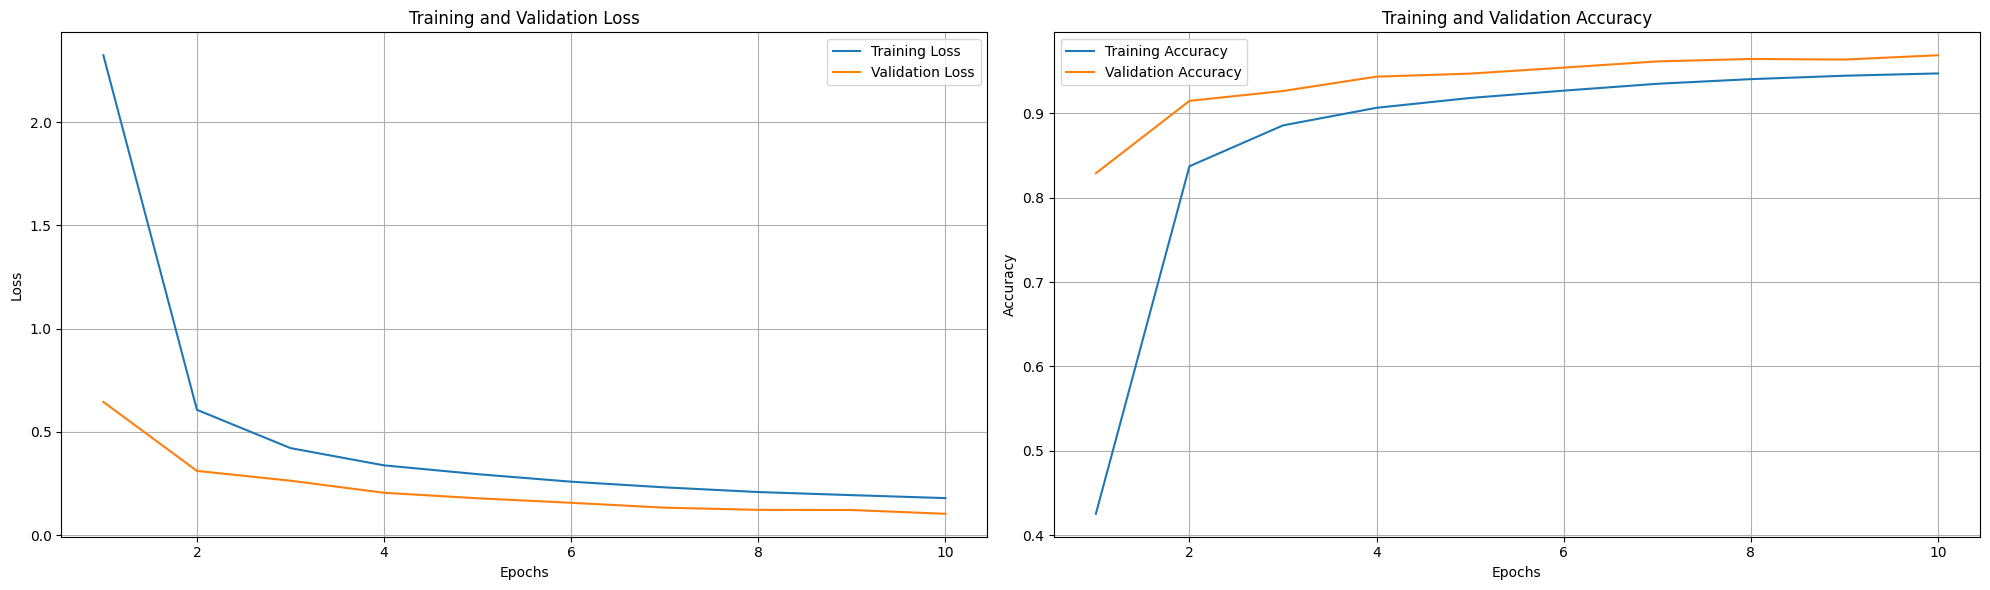

In [35]:
plot_training_curves(
    training_per_batch_losses, 
    training_per_batch_accuracies, 
    validation_per_batch_losses, 
    validation_per_batch_accuracies, 
    num_epochs, 
    jigsaw_train_dataloader, 
    jigsaw_val_dataloader
)

## Second pretext task: geometric transformation recognition

### Dataset class definition and transformations definition

In [41]:
class GeometricDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, perm_set=None):
        self.dataset = dataset
        self.perm_set = perm_set

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        perm_index = random.randint(0, len(self.perm_set) - 1)
        perm = self.perm_set[perm_index]

        # Apply the permutation to the image
        permuted_image = perm(image)

        return permuted_image, perm_index

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5699118..1.6988239].


Image shape: torch.Size([3, 128, 128]), Label: 1


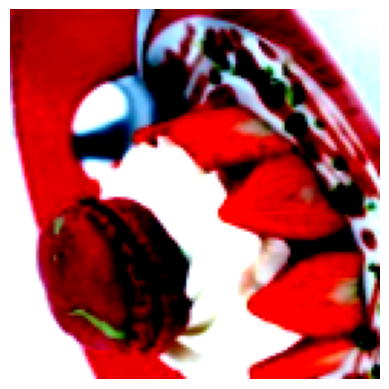

In [42]:
permutations = [
    v2.RandomRotation([0, 0], expand=True),
    v2.RandomRotation([90, 90], expand=True),
    v2.RandomRotation([180, 180], expand=True),
    v2.RandomRotation([270, 270], expand=True),
    v2.Compose([v2.CenterCrop((64, 64)), v2.Resize((128, 128))]),
]

geometric_dataset_train = GeometricDataset(train_dataset, perm_set=permutations)
geometric_dataset_val = GeometricDataset(val_dataset, perm_set=permutations)
geometric_train_dataloader = torch.utils.data.DataLoader(geometric_dataset_train, batch_size=16, shuffle=True)
geometric_val_dataloader = torch.utils.data.DataLoader(geometric_dataset_val, batch_size=16, shuffle=False)
image, label = geometric_dataset_train[100]

print(f"Image shape: {image.shape}, Label: {label}")
plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

### Training routine

In [43]:
second_task_model = torch.nn.Sequential(*(list(first_task_model.children())[:-1] + [nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.SiLU(),
            nn.Linear(1024, len(permutations))
        )]))
second_task_model.to(device)

num_epochs = 10
optimizer = torch.optim.AdamW(second_task_model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

training_per_batch_losses, training_per_batch_accuracies, validation_per_batch_losses, validation_per_batch_accuracies = run_training_routine(
    second_task_model,
    num_classes=len(permutations), 
    num_epochs=num_epochs, 
    training_dataloader=geometric_train_dataloader,
      validation_dataloader=geometric_val_dataloader, 
      criterion=nn.CrossEntropyLoss().to(device), 
      optimizer=optimizer, 
      scheduler=scheduler)

100%|██████████| 5253/5253 [17:01<00:00,  5.14it/s]


[Epoch 1] Training Loss: 0.6515 | Training Accuracy: 74.14%


100%|██████████| 470/470 [01:07<00:00,  6.94it/s]


[Epoch 1] Validation Loss: 0.4381 | Validation Accuracy: 83.44%


100%|██████████| 5253/5253 [08:17<00:00, 10.56it/s]


[Epoch 2] Training Loss: 0.5168 | Training Accuracy: 80.08%


100%|██████████| 470/470 [00:23<00:00, 20.23it/s]


[Epoch 2] Validation Loss: 0.3932 | Validation Accuracy: 85.56%


100%|██████████| 5253/5253 [08:16<00:00, 10.58it/s]


[Epoch 3] Training Loss: 0.4653 | Training Accuracy: 82.07%


100%|██████████| 470/470 [00:23<00:00, 20.35it/s]


[Epoch 3] Validation Loss: 0.3475 | Validation Accuracy: 87.25%


100%|██████████| 5253/5253 [08:18<00:00, 10.53it/s]


[Epoch 4] Training Loss: 0.4301 | Training Accuracy: 83.53%


100%|██████████| 470/470 [00:23<00:00, 20.12it/s]


[Epoch 4] Validation Loss: 0.3318 | Validation Accuracy: 87.75%


100%|██████████| 5253/5253 [08:17<00:00, 10.57it/s]


[Epoch 5] Training Loss: 0.4070 | Training Accuracy: 84.40%


100%|██████████| 470/470 [00:23<00:00, 20.31it/s]


[Epoch 5] Validation Loss: 0.3171 | Validation Accuracy: 88.38%


100%|██████████| 5253/5253 [08:25<00:00, 10.40it/s]


[Epoch 6] Training Loss: 0.3919 | Training Accuracy: 85.03%


100%|██████████| 470/470 [00:23<00:00, 20.41it/s]


[Epoch 6] Validation Loss: 0.3215 | Validation Accuracy: 87.85%


100%|██████████| 5253/5253 [08:19<00:00, 10.53it/s]


[Epoch 7] Training Loss: 0.3786 | Training Accuracy: 85.45%


100%|██████████| 470/470 [00:23<00:00, 20.34it/s]


[Epoch 7] Validation Loss: 0.2813 | Validation Accuracy: 89.41%


100%|██████████| 5253/5253 [08:22<00:00, 10.46it/s]


[Epoch 8] Training Loss: 0.3663 | Training Accuracy: 86.02%


100%|██████████| 470/470 [00:23<00:00, 20.14it/s]


[Epoch 8] Validation Loss: 0.2906 | Validation Accuracy: 89.15%


100%|██████████| 5253/5253 [08:19<00:00, 10.53it/s]


[Epoch 9] Training Loss: 0.3592 | Training Accuracy: 86.25%


100%|██████████| 470/470 [00:22<00:00, 20.57it/s]


[Epoch 9] Validation Loss: 0.2825 | Validation Accuracy: 89.24%


100%|██████████| 5253/5253 [08:16<00:00, 10.57it/s]


[Epoch 10] Training Loss: 0.3512 | Training Accuracy: 86.55%


100%|██████████| 470/470 [00:22<00:00, 20.64it/s]

[Epoch 10] Validation Loss: 0.2766 | Validation Accuracy: 89.56%


### Training and validation curves

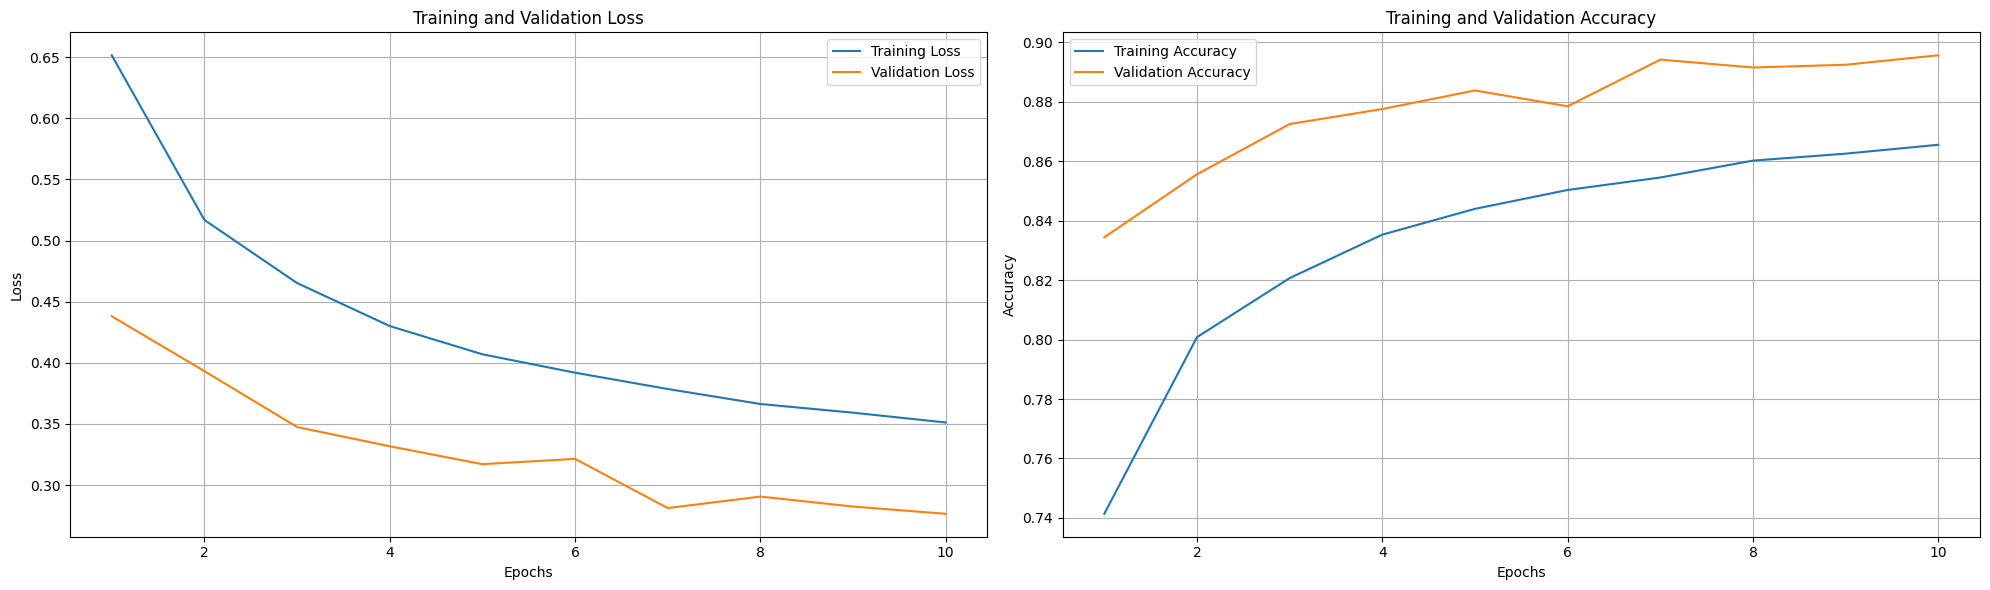

In [ ]:
plot_training_curves(
    training_per_batch_losses, 
    training_per_batch_accuracies, 
    validation_per_batch_losses, 
    validation_per_batch_accuracies, 
    num_epochs, 
    geometric_train_dataloader, 
    geometric_val_dataloader
)

## Final self-supervised classifier

In [49]:
self_supervised_classifier = torch.nn.Sequential(*(list(second_task_model.children())[:-1] + [nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.SiLU(),
            nn.Linear(1024, 251)
        )]))
self_supervised_classifier.to(device)

num_epochs = 30
optimizer = torch.optim.AdamW(self_supervised_classifier.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

training_per_batch_losses, training_per_batch_accuracies, validation_per_batch_losses, validation_per_batch_accuracies = run_training_routine(
    self_supervised_classifier,
    num_classes=251,
    num_epochs=num_epochs,
    training_dataloader=train_dataloader,
    validation_dataloader=val_dataloader,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=optimizer,
    scheduler=scheduler
)

100%|██████████| 1314/1314 [07:48<00:00,  2.80it/s]


[Epoch 1] Training Loss: 4.6262 | Training Accuracy: 7.63%


100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


[Epoch 1] Validation Loss: 4.0643 | Validation Accuracy: 14.41%


100%|██████████| 1314/1314 [07:45<00:00,  2.82it/s]


[Epoch 2] Training Loss: 3.9212 | Training Accuracy: 16.76%


100%|██████████| 118/118 [00:20<00:00,  5.69it/s]


[Epoch 2] Validation Loss: 3.5822 | Validation Accuracy: 22.51%


100%|██████████| 1314/1314 [07:45<00:00,  2.82it/s]


[Epoch 3] Training Loss: 3.5914 | Training Accuracy: 21.98%


100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


[Epoch 3] Validation Loss: 3.3222 | Validation Accuracy: 27.03%


100%|██████████| 1314/1314 [07:52<00:00,  2.78it/s]


[Epoch 4] Training Loss: 3.3689 | Training Accuracy: 25.95%


100%|██████████| 118/118 [00:21<00:00,  5.61it/s]


[Epoch 4] Validation Loss: 3.1740 | Validation Accuracy: 29.13%


100%|██████████| 1314/1314 [10:25<00:00,  2.10it/s]


[Epoch 5] Training Loss: 3.1988 | Training Accuracy: 29.05%


100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


[Epoch 5] Validation Loss: 3.0295 | Validation Accuracy: 32.81%


100%|██████████| 1314/1314 [08:19<00:00,  2.63it/s]


[Epoch 6] Training Loss: 3.0637 | Training Accuracy: 31.29%


100%|██████████| 118/118 [00:25<00:00,  4.56it/s]


[Epoch 6] Validation Loss: 2.9194 | Validation Accuracy: 35.18%


100%|██████████| 1314/1314 [08:15<00:00,  2.65it/s]


[Epoch 7] Training Loss: 2.9362 | Training Accuracy: 33.65%


100%|██████████| 118/118 [00:22<00:00,  5.35it/s]


[Epoch 7] Validation Loss: 2.8275 | Validation Accuracy: 36.48%


100%|██████████| 1314/1314 [10:30<00:00,  2.08it/s]


[Epoch 8] Training Loss: 2.8302 | Training Accuracy: 35.56%


100%|██████████| 118/118 [00:23<00:00,  5.12it/s]


[Epoch 8] Validation Loss: 2.7853 | Validation Accuracy: 37.63%


100%|██████████| 1314/1314 [07:25<00:00,  2.95it/s]


[Epoch 9] Training Loss: 2.7301 | Training Accuracy: 37.34%


100%|██████████| 118/118 [00:19<00:00,  6.03it/s]


[Epoch 9] Validation Loss: 2.7451 | Validation Accuracy: 38.29%


100%|██████████| 1314/1314 [10:03<00:00,  2.18it/s]


[Epoch 10] Training Loss: 2.6450 | Training Accuracy: 38.87%


100%|██████████| 118/118 [00:31<00:00,  3.79it/s]


[Epoch 10] Validation Loss: 2.7333 | Validation Accuracy: 38.54%


100%|██████████| 1314/1314 [10:40<00:00,  2.05it/s]


[Epoch 11] Training Loss: 2.5657 | Training Accuracy: 40.09%


100%|██████████| 118/118 [00:24<00:00,  4.73it/s]


[Epoch 11] Validation Loss: 2.6746 | Validation Accuracy: 39.91%


100%|██████████| 1314/1314 [12:54<00:00,  1.70it/s]


[Epoch 12] Training Loss: 2.4946 | Training Accuracy: 41.37%


100%|██████████| 118/118 [00:30<00:00,  3.85it/s]


[Epoch 12] Validation Loss: 2.6550 | Validation Accuracy: 40.48%


100%|██████████| 1314/1314 [13:44<00:00,  1.59it/s]


[Epoch 13] Training Loss: 2.4144 | Training Accuracy: 42.98%


100%|██████████| 118/118 [00:29<00:00,  4.01it/s]


[Epoch 13] Validation Loss: 2.6044 | Validation Accuracy: 41.34%


100%|██████████| 1314/1314 [13:39<00:00,  1.60it/s]


[Epoch 14] Training Loss: 2.3457 | Training Accuracy: 44.08%


100%|██████████| 118/118 [00:31<00:00,  3.75it/s]


[Epoch 14] Validation Loss: 2.6279 | Validation Accuracy: 40.84%


100%|██████████| 1314/1314 [13:08<00:00,  1.67it/s]


[Epoch 15] Training Loss: 2.2833 | Training Accuracy: 45.25%


100%|██████████| 118/118 [00:20<00:00,  5.82it/s]


[Epoch 15] Validation Loss: 2.6134 | Validation Accuracy: 41.77%


100%|██████████| 1314/1314 [07:41<00:00,  2.85it/s]


[Epoch 16] Training Loss: 2.2167 | Training Accuracy: 46.65%


100%|██████████| 118/118 [00:20<00:00,  5.74it/s]


[Epoch 16] Validation Loss: 2.5962 | Validation Accuracy: 42.40%


100%|██████████| 1314/1314 [07:40<00:00,  2.85it/s]


[Epoch 17] Training Loss: 2.1597 | Training Accuracy: 47.61%


100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


[Epoch 17] Validation Loss: 2.6079 | Validation Accuracy: 42.44%


100%|██████████| 1314/1314 [07:40<00:00,  2.85it/s]


[Epoch 18] Training Loss: 2.0973 | Training Accuracy: 48.83%


100%|██████████| 118/118 [00:20<00:00,  5.85it/s]


[Epoch 18] Validation Loss: 2.6059 | Validation Accuracy: 43.07%


100%|██████████| 1314/1314 [07:37<00:00,  2.87it/s]


[Epoch 19] Training Loss: 2.0395 | Training Accuracy: 49.94%


100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


[Epoch 19] Validation Loss: 2.6260 | Validation Accuracy: 42.64%


100%|██████████| 1314/1314 [07:37<00:00,  2.87it/s]


[Epoch 20] Training Loss: 1.9814 | Training Accuracy: 51.11%


100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


[Epoch 20] Validation Loss: 2.6075 | Validation Accuracy: 43.74%


100%|██████████| 1314/1314 [07:37<00:00,  2.87it/s]


[Epoch 21] Training Loss: 1.9299 | Training Accuracy: 52.18%


100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


[Epoch 21] Validation Loss: 2.5557 | Validation Accuracy: 44.35%


100%|██████████| 1314/1314 [07:36<00:00,  2.88it/s]


[Epoch 22] Training Loss: 1.8743 | Training Accuracy: 53.13%


100%|██████████| 118/118 [00:20<00:00,  5.81it/s]


[Epoch 22] Validation Loss: 2.5931 | Validation Accuracy: 43.90%


100%|██████████| 1314/1314 [07:38<00:00,  2.87it/s]


[Epoch 23] Training Loss: 1.8326 | Training Accuracy: 54.02%


100%|██████████| 118/118 [00:20<00:00,  5.82it/s]


[Epoch 23] Validation Loss: 2.6225 | Validation Accuracy: 43.55%


100%|██████████| 1314/1314 [07:38<00:00,  2.86it/s]


[Epoch 24] Training Loss: 1.7813 | Training Accuracy: 55.03%


100%|██████████| 118/118 [00:20<00:00,  5.70it/s]


[Epoch 24] Validation Loss: 2.6222 | Validation Accuracy: 44.22%


100%|██████████| 1314/1314 [07:39<00:00,  2.86it/s]


[Epoch 25] Training Loss: 1.7415 | Training Accuracy: 55.70%


100%|██████████| 118/118 [00:20<00:00,  5.82it/s]


[Epoch 25] Validation Loss: 2.6610 | Validation Accuracy: 43.88%


100%|██████████| 1314/1314 [07:36<00:00,  2.88it/s]


[Epoch 26] Training Loss: 1.6841 | Training Accuracy: 56.72%


100%|██████████| 118/118 [00:20<00:00,  5.80it/s]


[Epoch 26] Validation Loss: 2.6734 | Validation Accuracy: 44.13%


100%|██████████| 1314/1314 [07:35<00:00,  2.88it/s]


[Epoch 27] Training Loss: 1.6460 | Training Accuracy: 57.43%


100%|██████████| 118/118 [00:20<00:00,  5.83it/s]


[Epoch 27] Validation Loss: 2.6528 | Validation Accuracy: 44.82%


100%|██████████| 1314/1314 [07:40<00:00,  2.86it/s]


[Epoch 28] Training Loss: 1.4511 | Training Accuracy: 62.13%


100%|██████████| 118/118 [00:20<00:00,  5.73it/s]


[Epoch 28] Validation Loss: 2.6460 | Validation Accuracy: 45.71%


100%|██████████| 1314/1314 [07:39<00:00,  2.86it/s]


[Epoch 29] Training Loss: 1.3940 | Training Accuracy: 63.32%


100%|██████████| 118/118 [00:20<00:00,  5.78it/s]


[Epoch 29] Validation Loss: 2.6800 | Validation Accuracy: 45.55%


100%|██████████| 1314/1314 [07:40<00:00,  2.86it/s]


[Epoch 30] Training Loss: 1.3549 | Training Accuracy: 64.23%


100%|██████████| 118/118 [00:20<00:00,  5.82it/s]

[Epoch 30] Validation Loss: 2.6852 | Validation Accuracy: 45.68%


### Training and validation curves

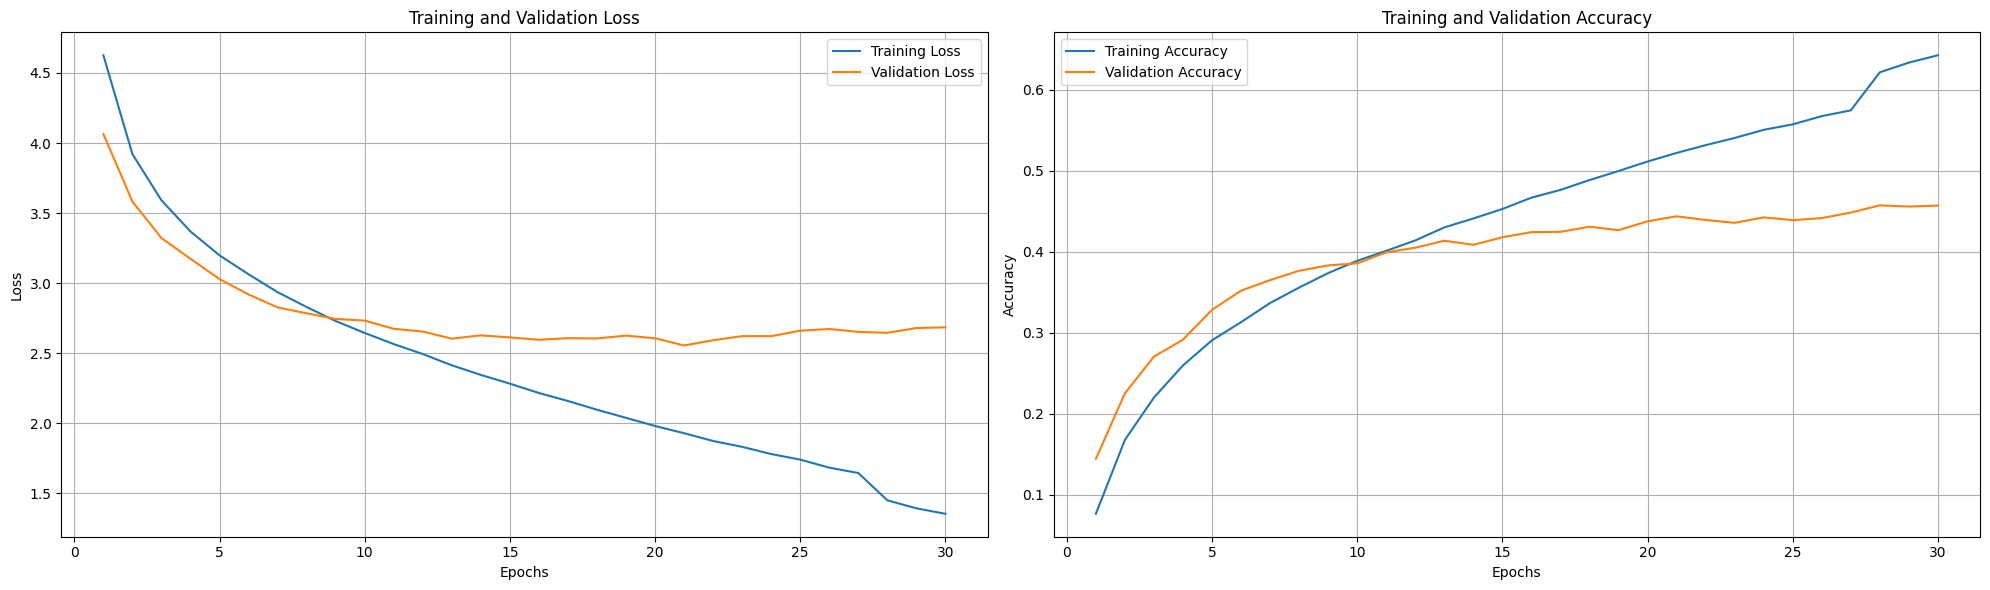

In [50]:
plot_training_curves(
    training_per_batch_losses, 
    training_per_batch_accuracies, 
    validation_per_batch_losses, 
    validation_per_batch_accuracies, 
    num_epochs, 
    train_dataloader, 
    val_dataloader
)

### Metrics

In [51]:
compute_metrics(self_supervised_classifier, test_dataloader)

100%|██████████| 188/188 [01:58<00:00,  1.59it/s]

Accuracy: 48.53%
F1 Score (Macro): 46.62%
F1 Score (Weighted): 48.21%
Precision (Macro): 47.39%
Precision (Weighted): 49.10%
Recall (Macro): 47.13%
